In [9]:
from utils.dataset import  CustomDataset
import os
import warnings
warnings.filterwarnings("ignore")
import glob
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import sys
import pandas as pd
from tqdm import tqdm
import threading
import random
# import rasterio
import os
import numpy as np
import sys
from sklearn.utils import shuffle as shuffle_lists
import numpy as np
from sklearn.model_selection import train_test_split
import joblib

import torch

#default
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

#trasnform
from torchvision import transforms

#dataset
from utils.dataset import CustomDataset
from torch.utils.data import DataLoader, random_split
import torchvision.models as models
from torchsummary import summary
from torchsampler import ImbalancedDatasetSampler

#metric
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import torchmetrics.functional as tf

#numeric
import numpy as np
import pandas as pd 

#visualization
import matplotlib.pyplot as plt

#system 
from tqdm import tqdm
import os 
import wandb
import datetime


In [10]:
now = datetime.datetime.now()
formatted_now = now.strftime("%Y%m%d%H%M")
checkpoint_datetime = formatted_now
print(f"#"*30, "SAVE TIME", "#"*30)
print(f"#"*30, checkpoint_datetime, "#"*30)

############################## SAVE TIME ##############################
############################## 202403221609 ##############################


In [11]:
train_csv = '../../dataset/train_meta.csv'

train_transform = transforms.Compose([
    # transforms.Resize((512,512), antialias= True),
    # transforms.RandomApply([
    #     transforms.RandomRotation(degrees = 30),
    #     transforms.RandomVerticalFlip(p= 0.5),
    #     transforms.RandomVerticalFlip(p=0.5),
    #     transforms.RandomCrop(size =224, scale= (0.8, 1.2), ratio = (0.75, 1.2), antialias = True),
    #     transforms.ColorJitter(brightness= 0.2, contrast = 0.2)
    # ]),
    transforms.ToTensor()
])
tr_batch = 88
vl_batch = 16

dataset = CustomDataset(
    csv_path= train_csv,
    transform= None, #None으로 세팅
    MAX_PIXEL_VALUE= 65535,
    band = (7,6,2) #기존 세팅 
)

# 훈련 및 검증 세트 분할
train_size = int(0.8 * len(dataset))
valid_size = len(dataset) - train_size 
train_dataset, valid_dataset = random_split(dataset, [train_size, valid_size])
train_loader = DataLoader(
    dataset = train_dataset,
    batch_size = tr_batch
    # sampler= ImbalancedDatasetSampler(train_dataset),
)
valid_loader = DataLoader(dataset = valid_dataset, batch_size = vl_batch, shuffle= False)



torch.Size([88, 256, 256, 3])


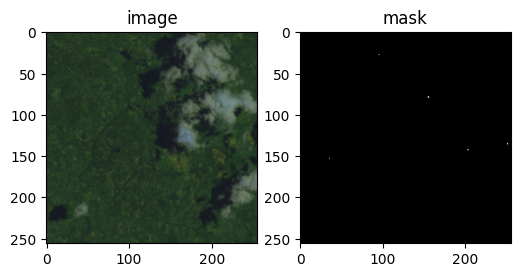

torch.Size([16, 256, 256, 3])


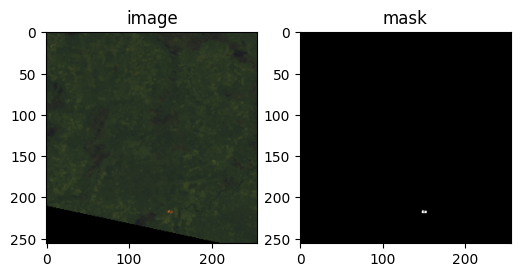

In [12]:
for images, masks in train_loader:
    print(images.shape)
    idx = 0
    plt.figure(figsize=(6,4))
    plt.subplot(121)
    plt.imshow(images[idx])
    plt.title('image')
    plt.subplot(122)
    plt.imshow(masks[idx], cmap= 'gray')
    plt.title('mask')
    plt.show()
    break

for images, masks in valid_loader:
    print(images.shape)
    idx = 0
    plt.figure(figsize=(6,4))
    plt.subplot(121)
    plt.imshow(images[idx])
    plt.title('image')
    plt.subplot(122)
    plt.imshow(masks[idx], cmap= 'gray')
    plt.title('mask')
    plt.show()
    break

In [13]:
#model
sys.path.append('../')
from network.models import get_pretrained_model

# if torch.cuda.is_available():
#     device = 'cuda'
#     torch.cuda.manual_seed_all(42)
device = 'cuda'
# # random seed 고정
# random.seed(42)
# if torch.cuda.is_available():
#     device = torch.device('cuda')
#     torch.cuda.manual_seed_all(42)
# else:
#     device = torch.device('cuda')
#     torch.manual_seed_all(42)

# # model & cost func & optimizer 정의
############################ V1~2 #############################
model = get_pretrained_model('manet').get()
############################ V3~4 #############################
# model = AttU_Net(img_ch= 3, output_ch= 1)
# model = get_pretrained_model('attunet').get()
# model = get_pretrained_model('r2attunet').get()
############################ V5 #############################
# model = get_pretrained_model('unet++').get()
############################ V6 #############################
# model = get_pretrained_model('manet').get()

model.to(device)

lr = 0.0001
optimizer = torch.optim.AdamW(model.parameters(), lr = lr)
scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda= lambda epoch: 0.95**epoch)

loss = nn.BCEWithLogitsLoss()

print(f'device : {device}')
# summary(model, input_size=(3, 224, 224))



Model name : manet
device : cuda


In [14]:
metrics = {
    'tr_bce' : [],
    'vl_bce' : [],
    'tr_iou' : [],
    'vl_iou' : [],
}
epoch, epochs = 0, 200
early_stopping_epochs, early_stopping_cnt= 10, 0
SAVE_DIR = '../../satellite_model'
best_loss = float('inf')


In [15]:
def checkpoint(SAVE_DIR, checkpoint_datetime, model, optimizer, lr, loss, metrics, epoch, epochs, images, masks, preds):
    # loss plot
    plt.figure(figsize=(10, 7))
    plt.subplot(121)
    plt.plot(metrics['tr_bce'], label='Train Loss')
    plt.plot(metrics['vl_bce'], label='Valid Loss')
    plt.title("BCE | DOWN GOOD")
    plt.legend()
    plt.subplot(122)
    plt.plot(metrics['tr_iou'], label='Train IoU')
    plt.plot(metrics['vl_iou'], label='Valid IoU')
    plt.title("mIOU | UP GOOD")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(SAVE_DIR, checkpoint_datetime+f'_{epoch}_{epochs}_loss.png'))
    plt.close()
    
    # mask plot
    plt.figure(figsize=(10, 7))
    plt.subplot(131)
    plt.imshow(images[0].cpu().permute(1,2,0))
    plt.title('image')
    plt.axis('off')
    plt.subplot(132)
    plt.imshow(masks[0].cpu().permute(1,2,0))
    plt.title('mask')
    plt.axis('off')
    plt.subplot(133)
    plt.imshow(preds[0].cpu().permute(1,2,0))
    plt.title('pred')
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(os.path.join(SAVE_DIR, checkpoint_datetime+f'_{epoch}_{epochs}_mask.png'))
    plt.close()
    
    torch.save({
        "model" : f"{epoch}",
        "epoch" : epoch,
        "epochs" : epochs,
        "model_state_dict" : model.state_dict(),
        "optimizer_state_dict" : optimizer.state_dict(),
        "learning_rate" : lr,
        "loss" : loss,
        "metric" : metrics,
        "description" : f"segmentation model training status : {epoch}/{epochs}"
    },
    os.path.join(SAVE_DIR, checkpoint_datetime+f'_{epoch}_{epochs}.pt'))
    print(f"#"*30, f"SAVE PATH : {SAVE_DIR}", "#"*30)
    
def calculate_iou(preds, masks, threshold=0.5):
    # 예측 마스크를 이진 형태로 변환
    preds = (preds > threshold).float()
    
    intersection = torch.sum(preds * masks)
    union = torch.sum((preds + masks) > 0)
    
    iou = (intersection + 1e-7) / (union + 1e-7)  # 0으로 나누는 경우를 방지하기 위해 작은 값(1e-7)을 추가
    
    return iou

In [16]:
for epoch in tqdm(range(epoch, epochs), desc="Training Progress"):
    train_losses, valid_losses = 0., 0.
    train_ious, valid_ious = 0., 0.
    
    model.train()
    for _, (images, masks) in tqdm(enumerate(train_loader), total=len(train_loader)):
        images, masks = images.to(device), masks.to(device)
        images = images.permute(0,3,1,2)
        masks = masks.permute(0,3,1,2)
        
        preds = model(images) 

        train_loss = loss(preds, masks).to(device)
        train_iou = calculate_iou(preds, masks).cpu().detach().numpy()
        
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        train_losses += train_loss.item()
        train_ious += train_iou
        break 
    scheduler.step()
    
    metrics['tr_bce'].append(train_losses / len(train_loader))
    metrics['tr_iou'].append(train_ious / len(train_loader))
    print(f"Epoch : {epoch}/{epochs} | Train Loss : {train_losses / len(train_loader)}")
    print(f"Epoch : {epoch}/{epochs} | Train IOU : {train_ious / len(train_loader)}")
    
    with torch.no_grad():
        model.eval()
        for _, (images, masks) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
            images, masks = images.to(device), masks.to(device)
            images = images.permute(0,3,1,2)
            masks = masks.permute(0,3,1,2)

            preds = model(images)
            valid_loss = loss(preds, masks).to(device)
            valid_iou = calculate_iou(preds, masks).cpu().detach().numpy()
        
            valid_losses += valid_loss.item()
            valid_ious += valid_iou
            break
            

    metrics['vl_bce'].append(valid_losses / len(valid_loader))
    metrics['vl_iou'].append(valid_ious / len(valid_loader))
    print(f"Epoch : {epoch}/{epochs} | Valid Loss : {valid_losses / len(valid_loader)}")
    print(f"Epoch : {epoch}/{epochs} | Valid IOU : {valid_ious / len(valid_loader)}")

    # Early Stopping
    if valid_losses < best_loss:
        best_loss = valid_losses
        early_stopping_cnt = 0
        # checkpoint(SAVE_DIR, checkpoint_datetime, model, optimizer, lr, loss, metrics, epoch, epochs, images, masks, preds)

    else:
        early_stopping_cnt += 1
        if early_stopping_cnt >= early_stopping_epochs:
            print(f"Early Stops!!! : {epoch}/{epochs}")
            # checkpoint(SAVE_DIR, checkpoint_datetime, model, optimizer, lr, loss, metrics, epoch, epochs, images, masks, preds)
    
    # Validation 성능이 이전보다 우수한 경우 모델 저장
    try:        
        if valid_losses > np.array(metrics['vl_bce'])[:-1].max() and epoch%10 == 0:
            pass
            # checkpoint(SAVE_DIR, checkpoint_datetime, model, optimizer, lr, loss, metrics, epoch, epochs, images, masks, preds)
    except Exception as e:
        print(e)
        pass

Training Progress:   0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/306 [00:00<?, ?it/s]


Epoch : 0/200 | Train Loss : 0.0022341449276294585
Epoch : 0/200 | Train IOU : 2.7263011278134155e-06


Training Progress:   0%|          | 1/200 [00:00<02:50,  1.16it/s]

Epoch : 0/200 | Valid Loss : 0.0015653400194077264
Epoch : 0/200 | Valid IOU : 6.417661375868717e-13
zero-size array to reduction operation maximum which has no identity


  0%|          | 0/306 [00:00<?, ?it/s]


Epoch : 1/200 | Train Loss : 0.002165564135009167
Epoch : 1/200 | Train IOU : 3.928446828758989e-06


Training Progress:   1%|          | 2/200 [00:01<02:47,  1.18it/s]

Epoch : 1/200 | Valid Loss : 0.001619343672479902
Epoch : 1/200 | Valid IOU : 6.152331950771112e-13


  0%|          | 0/306 [00:00<?, ?it/s]


Epoch : 2/200 | Train Loss : 0.00208335920097002
Epoch : 2/200 | Train IOU : 7.282218171490564e-06


Training Progress:   2%|▏         | 3/200 [00:02<02:42,  1.21it/s]

Epoch : 2/200 | Valid Loss : 0.0016431902136121478
Epoch : 2/200 | Valid IOU : 1.1048502554850919e-05


  0%|          | 0/306 [00:00<?, ?it/s]


Epoch : 3/200 | Train Loss : 0.0020256130134358127
Epoch : 3/200 | Train IOU : 8.701794975577226e-06


Training Progress:   2%|▏         | 4/200 [00:03<02:39,  1.23it/s]

Epoch : 3/200 | Valid Loss : 0.001650107190722511
Epoch : 3/200 | Valid IOU : 6.349206213695e-13


  0%|          | 0/306 [00:00<?, ?it/s]


Epoch : 4/200 | Train Loss : 0.0019662672398137113
Epoch : 4/200 | Train IOU : 1.3418798487073456e-05


Training Progress:   2%|▎         | 5/200 [00:04<02:38,  1.23it/s]

Epoch : 4/200 | Valid Loss : 0.0016274947495687575
Epoch : 4/200 | Valid IOU : 6.349206213695e-13


  0%|          | 0/306 [00:00<?, ?it/s]


Epoch : 5/200 | Train Loss : 0.0019109011475556817
Epoch : 5/200 | Train IOU : 1.773293574456296e-05


Training Progress:   3%|▎         | 6/200 [00:04<02:37,  1.23it/s]

Epoch : 5/200 | Valid Loss : 0.0015961116268521263
Epoch : 5/200 | Valid IOU : 6.349206213695e-13


  0%|          | 0/306 [00:00<?, ?it/s]


Epoch : 6/200 | Train Loss : 0.0018530710070740943
Epoch : 6/200 | Train IOU : 2.0444919690002803e-05


Training Progress:   4%|▎         | 7/200 [00:05<02:36,  1.24it/s]

Epoch : 6/200 | Valid Loss : 0.0015620812064125423
Epoch : 6/200 | Valid IOU : 6.349206213695e-13


  0%|          | 0/306 [00:00<?, ?it/s]


Epoch : 7/200 | Train Loss : 0.0018085921122357736
Epoch : 7/200 | Train IOU : 2.3828470909030608e-05


Training Progress:   4%|▍         | 8/200 [00:06<02:34,  1.24it/s]

Epoch : 7/200 | Valid Loss : 0.0015326187724158877
Epoch : 7/200 | Valid IOU : 6.349206213695e-13


  0%|          | 0/306 [00:00<?, ?it/s]


Epoch : 8/200 | Train Loss : 0.0017636589754640667
Epoch : 8/200 | Train IOU : 2.772272473164633e-05


Training Progress:   4%|▍         | 9/200 [00:07<02:33,  1.24it/s]

Epoch : 8/200 | Valid Loss : 0.0015094254698072161
Epoch : 8/200 | Valid IOU : 6.265663913633072e-13


  0%|          | 0/306 [00:00<?, ?it/s]


Epoch : 9/200 | Train Loss : 0.0017281772654040967
Epoch : 9/200 | Train IOU : 3.413655764721578e-05


Training Progress:   5%|▌         | 10/200 [00:08<02:32,  1.25it/s]

Epoch : 9/200 | Valid Loss : 0.0014888488111041841
Epoch : 9/200 | Valid IOU : 5.997361337709403e-13


  0%|          | 0/306 [00:00<?, ?it/s]


Epoch : 10/200 | Train Loss : 0.0016921372974620147
Epoch : 10/200 | Train IOU : 4.09406147215491e-05


Training Progress:   6%|▌         | 11/200 [00:08<02:32,  1.24it/s]

Epoch : 10/200 | Valid Loss : 0.0014707871845790318
Epoch : 10/200 | Valid IOU : 5.589090037344271e-13


  0%|          | 0/306 [00:00<?, ?it/s]


Epoch : 11/200 | Train Loss : 0.0016608487546833511
Epoch : 11/200 | Train IOU : 4.7697259563636156e-05


Training Progress:   6%|▌         | 12/200 [00:09<02:31,  1.24it/s]

Epoch : 11/200 | Valid Loss : 0.0014543595768156505
Epoch : 11/200 | Valid IOU : 5.291005398361513e-13


  0%|          | 0/306 [00:00<?, ?it/s]


Epoch : 12/200 | Train Loss : 0.0016314554837794086
Epoch : 12/200 | Train IOU : 5.560989181200663e-05


Training Progress:   6%|▋         | 13/200 [00:10<02:30,  1.24it/s]

Epoch : 12/200 | Valid Loss : 0.0014387939657483782
Epoch : 12/200 | Valid IOU : 5.550005560948196e-13


  0%|          | 0/306 [00:00<?, ?it/s]


Epoch : 13/200 | Train Loss : 0.001604185092682932
Epoch : 13/200 | Train IOU : 6.285223963798261e-05


Training Progress:   7%|▋         | 14/200 [00:11<02:29,  1.24it/s]

Epoch : 13/200 | Valid Loss : 0.00142336714835394
Epoch : 13/200 | Valid IOU : 1.0797970129975251e-05


  0%|          | 0/306 [00:00<?, ?it/s]


Epoch : 14/200 | Train Loss : 0.0015787949749067717
Epoch : 14/200 | Train IOU : 7.122764789980221e-05


Training Progress:   8%|▊         | 15/200 [00:12<02:29,  1.24it/s]

Epoch : 14/200 | Valid Loss : 0.0014079343704950242
Epoch : 14/200 | Valid IOU : 5.398985619346301e-06


  0%|          | 0/306 [00:00<?, ?it/s]


Epoch : 15/200 | Train Loss : 0.0015551995218189712
Epoch : 15/200 | Train IOU : 7.770387638433306e-05


Training Progress:   8%|▊         | 16/200 [00:12<02:28,  1.24it/s]

Epoch : 15/200 | Valid Loss : 0.0013909057492301577
Epoch : 15/200 | Valid IOU : 5.175983649622192e-13


  0%|          | 0/306 [00:00<?, ?it/s]


Epoch : 16/200 | Train Loss : 0.0015335147287331376
Epoch : 16/200 | Train IOU : 8.690072333111482e-05


Training Progress:   8%|▊         | 17/200 [00:13<02:27,  1.24it/s]

Epoch : 16/200 | Valid Loss : 0.00137356093951634
Epoch : 16/200 | Valid IOU : 4.800307307735386e-13


  0%|          | 0/306 [00:00<?, ?it/s]


Epoch : 17/200 | Train Loss : 0.0015138418845881045
Epoch : 17/200 | Train IOU : 9.517970014046999e-05


Training Progress:   9%|▉         | 18/200 [00:14<02:26,  1.24it/s]

Epoch : 17/200 | Valid Loss : 0.0013568753287905738
Epoch : 17/200 | Valid IOU : 4.76190482548301e-13


  0%|          | 0/306 [00:00<?, ?it/s]


Epoch : 18/200 | Train Loss : 0.0014958707920086928
Epoch : 18/200 | Train IOU : 0.0001023613841705073


Training Progress:  10%|▉         | 19/200 [00:15<02:25,  1.24it/s]

Epoch : 18/200 | Valid Loss : 0.001339257898784819
Epoch : 18/200 | Valid IOU : 1.3709898727635542e-05


  0%|          | 0/306 [00:00<?, ?it/s]


Epoch : 19/200 | Train Loss : 0.0014793644933139578
Epoch : 19/200 | Train IOU : 0.00011057955718118381


Training Progress:  10%|█         | 20/200 [00:16<02:26,  1.23it/s]

Epoch : 19/200 | Valid Loss : 0.0013224062465486072
Epoch : 19/200 | Valid IOU : 4.206630235005702e-06


  0%|          | 0/306 [00:00<?, ?it/s]


Epoch : 20/200 | Train Loss : 0.0014642074801563436
Epoch : 20/200 | Train IOU : 0.00011778436601161957


Training Progress:  10%|█         | 21/200 [00:17<02:24,  1.23it/s]

Epoch : 20/200 | Valid Loss : 0.0013049873567762829
Epoch : 20/200 | Valid IOU : 8.705493417524157e-06


  0%|          | 0/306 [00:00<?, ?it/s]


Epoch : 21/200 | Train Loss : 0.001450116630473168
Epoch : 21/200 | Train IOU : 0.00012456493001747755


Training Progress:  11%|█         | 22/200 [00:17<02:23,  1.24it/s]

Epoch : 21/200 | Valid Loss : 0.0012879805905478341
Epoch : 21/200 | Valid IOU : 8.642295419815041e-06


  0%|          | 0/306 [00:00<?, ?it/s]


Epoch : 22/200 | Train Loss : 0.0014369823769027111
Epoch : 22/200 | Train IOU : 0.00013293501208810245


Training Progress:  12%|█▏        | 23/200 [00:18<02:22,  1.24it/s]

Epoch : 22/200 | Valid Loss : 0.0012746043148494902
Epoch : 22/200 | Valid IOU : 1.9974432264765105e-05


  0%|          | 0/306 [00:00<?, ?it/s]


Epoch : 23/200 | Train Loss : 0.0014247173577352286
Epoch : 23/200 | Train IOU : 0.00013872910461394615


Training Progress:  12%|█▏        | 24/200 [00:19<02:21,  1.24it/s]

Epoch : 23/200 | Valid Loss : 0.0012556250606264388
Epoch : 23/200 | Valid IOU : 1.1964584700763226e-05


  0%|          | 0/306 [00:00<?, ?it/s]


Epoch : 24/200 | Train Loss : 0.001413250475927116
Epoch : 24/200 | Train IOU : 0.00014457453553583108


Training Progress:  12%|█▎        | 25/200 [00:20<02:20,  1.24it/s]

Epoch : 24/200 | Valid Loss : 0.0012417796112242198
Epoch : 24/200 | Valid IOU : 2.004168705926055e-05


  0%|          | 0/306 [00:00<?, ?it/s]


Epoch : 25/200 | Train Loss : 0.001402603644950717
Epoch : 25/200 | Train IOU : 0.00014925765153629328


Training Progress:  13%|█▎        | 26/200 [00:21<02:20,  1.24it/s]

Epoch : 25/200 | Valid Loss : 0.0012258570818673997
Epoch : 25/200 | Valid IOU : 1.190476163866974e-05


  0%|          | 0/306 [00:00<?, ?it/s]


Epoch : 26/200 | Train Loss : 0.0013926290219126185
Epoch : 26/200 | Train IOU : 0.00015191112955411276


Training Progress:  14%|█▎        | 27/200 [00:21<02:20,  1.23it/s]

Epoch : 26/200 | Valid Loss : 0.0012096521400270007
Epoch : 26/200 | Valid IOU : 3.827898208761499e-06


Training Progress:  14%|█▎        | 27/200 [00:22<02:21,  1.22it/s]


KeyboardInterrupt: 